# Imports

In [1]:
# Imports
from requests import get
from json import loads
from pandas import DataFrame, to_datetime, isnull, concat, date_range
from matplotlib.pyplot import show

# Activity 1

## 1.1 Sub-activity: Open Data COVID-19 API

## Task 1

In [2]:
# The Google Python Style Guide has been followed throughout each task.
# 

def get_API_data(filters, structure):
    """Sends a specific query to the API and retrieves all the data provided
        by the API that matches the query.

    Args:
        filters (dictionary): Filters to be passed to the query.
        structure (dictionary): Specifies what information the query should
            return.

    Returns:
        (list of dictionaries): Data returned by the query.
    """
    # Formats the filters into the appropriate API format.
    structured_filters = "filters="
    for key, value in filters.items():
        structured_filters += (key + "=" + value + ";")
    # Removes the last ";" as we are not adding another filter.
    structured_filters = structured_filters[:-1]
    
    data = []
    # Page number to iterate through multiple pages until a page is returned
    # with no data.
    page = 1  
    while True:  # While we have not encountered a page with no data.
        # Formats the API request in the appropriate format.
        endpoint = ("https://api.coronavirus.data.gov.uk/v1/data?" +
                    structured_filters + "&"
                    "structure=" + str(structure).replace("\'", "\"") +
                    "&page=" + str(page))
        req = get(endpoint)
        if req.status_code == 200:  # If the request successfully returns data.
            # Adds the data on the current page into the list.
            data += loads(req.text)["data"]
            page += 1  # Increments the page number for the next API request.
        else: break # Else there is no more data to be downloaded.
    return data

## Task 2

In [3]:
def get_all_data():
    """Calls the get_API_data function for each nation and region.

    Returns:
        results_json_national (list of dictionaries): List of the requested
            data by nation.
        results_json_regional (list of dictionaries): List of the requested
            data by region.
    """
    # Lists to hold the requested data.
    results_json_national = []
    results_json_regional = []
    # List of two lists, the first list representing the names of the nations
    # to query, the second list representing the names of the regions. Used to
    # iterate through each location.
    nations_and_regions = [["england", "wales", "scotland", "northern ireland"],
                           ["east midlands", "east of england", "london",
                            "north east", "north west", "south east",
                            "south west", "west midlands",
                            "yorkshire and the humber"]]
    # Lists used to distinguish if adding to national vs regional results.
    results = [results_json_national, results_json_regional]
    location_type = ["nation", "region"]

    # For each of the two lists (nation and region names) specified above.
    # If loc_index = 0, we are using nations. If loc_index = 1, we are using regions.
    for loc_index in range(len(nations_and_regions)):
        # For each nation or region.
        for location in nations_and_regions[loc_index]:
            # Retrieves data for that location using "get_API_data" function.
            # Note: for "cumulative_vaccinated", the "cumPeopleVaccinatedSecondDoseByVaccinationDate"
            # metric is used as specified in the 15/12/2022 LGT.
            data = get_API_data({"areaType": location_type[loc_index],
                                 "areaName": location},
                                {"date": "date", "name": "areaName",
                                "daily_cases": "newCasesByPublishDate",
                                 "cumulative_cases": "cumCasesByPublishDate",
                                 "daily_deaths": "newDeaths28DaysByPublishDate",
                                 "cumulative_deaths": "cumDeaths28DaysByPublishDate",
                                 "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
                                 "vaccination_age": "vaccinationsAgeDemographics"})
            # Adds the results into its appropriate list.
            results[loc_index] += data
    return results[0], results[1]

results_json_national, results_json_regional = get_all_data()

# 1.2 Sub-activity: Shaping the COVID data into different dataframes

## Task 3

In [4]:
# Concatenates the two lists of dictionaries into a single list.
results = results_json_national + results_json_regional

## Task 4

In [5]:
# Transforms the "results" list into a DataFrame.
covid_data = DataFrame(results)

## Task 5

In [6]:
# Drops all rows where name == "England".
covid_data = covid_data.drop(covid_data[covid_data.name == "England"].index)

## Task 6

In [7]:
# Renames "name" column to "area".
covid_data = covid_data.rename(columns={"name": "area"})

## Task 7

In [8]:
# Converts "date" column to datetime type.
covid_data["date"] = to_datetime(covid_data["date"])

## Task 8

In [9]:
print("Here is a summary of the \"covid_data\" DataFrame:")
print(covid_data.describe())
print("\n")

for column in covid_data.columns:  # For each column in the DataFrame.
    # Calculates a list of which rows have missing values, saving the length of
    # this list (for current column).
    missing_rows = len(covid_data[isnull(covid_data[column])])
    print(column + " has " + str(missing_rows) + " missing values.")
    
# Iterates through each column; for each column, a DataFrame is produced using 
# the "isnull" method of either "True" or "False" values mapping to which rows 
# contain missing values. Using this DataFrame, filters the "covid_data"
# DataFrame to produce a DataFrame containing only the rows which have missing
# values (for the current column). The length of this DataFrame is saved and
# printed.

Here is a summary of the "covid_data" DataFrame:
         daily_cases  cumulative_cases  daily_deaths  cumulative_deaths  \
count   11603.000000      1.160300e+04  10242.000000       10254.000000   
mean     2039.692924      8.409227e+05     15.628198       10942.921201   
std      4223.353642      8.850755e+05     30.449637        6655.867575   
min         0.000000      1.000000e+00      0.000000           1.000000   
25%        42.000000      1.124250e+05      0.000000        5726.000000   
50%       614.000000      5.088060e+05      5.000000       10146.000000   
75%      2681.000000      1.435590e+06     17.000000       16204.000000   
max    137260.000000      3.310961e+06    459.000000       27619.000000   

       cumulative_vaccinated  
count           7.369000e+03  
mean            3.281834e+06  
std             2.013671e+06  
min             8.000000e+00  
25%             1.821273e+06  
50%             3.766317e+06  
75%             4.483927e+06  
max             7.085029e+0

## Task 9

In [10]:
# List of all the nations and regions.
locations = ["Wales", "Scotland", "Northern Ireland",
             "East Midlands", "East of England", "London", "North East",
             "North West", "South East", "South West", "West Midlands",
             "Yorkshire and The Humber"]
# List of names of each cumulative column.
col_names = ["cumulative_deaths", "cumulative_cases", "cumulative_vaccinated"]

for location in locations:  # For each location.
    # Fill in any missing values for each cumulative column if there is a
    # preceding non-missing value from an earlier date (on the condition that
    # both rows have the same "area".)
    covid_data.loc[covid_data.area == location, col_names] = covid_data.loc[
        covid_data.area == location, col_names].fillna(method="bfill")

## Task 10

In [11]:
# List of each cumulative column.
col_list = [covid_data.cumulative_deaths, covid_data.cumulative_cases,
            covid_data.cumulative_vaccinated]

for column in col_list: # For each of the cumulative columns.
    # Drop the row if any of that columns values are missing.
    covid_data = covid_data.drop(covid_data[column == float("Nan")].index)

## Task 11

In [12]:
# Calculates 7 day rolling averages for daily cases and deaths. Saves these as 
# new columns.
covid_data["daily_cases_roll_avg"] = covid_data["daily_cases"].rolling(7).sum()
covid_data["daily_deaths_roll_avg"] = covid_data["daily_deaths"].rolling(7).sum()

## Task 12

In [13]:
# Drops the "daily_cases" and "daily_deaths" columns.
covid_data = covid_data.drop(["daily_cases", "daily_deaths"], axis=1)

## Task 13

In [14]:
# Creates a new DataFrame with "covid_data" columns "date", "area" and
# "vaccination_age". Drops the "vaccination_age" column from "covid_data".
covid_data_vaccinations = covid_data[["date", "area", "vaccination_age"]].copy()
covid_data = covid_data.drop(["vaccination_age"], axis=1)

## Task 14

In [15]:
# This method takes under an hour to execute but does produce the desired
# result. I couldn't figure out how to use group_by to make it more efficient.
# Regardless, any further graph plotting tasks that use
# "covid_data_vaccinations_wide" do work despite task 14 being inefficient.

covid_data_vaccinations_wide = DataFrame()
# For each row in "covid_data_vaccinations".
for _, row in covid_data_vaccinations.iterrows():  
    current_list = row["vaccination_age"]
    # If the current row is not empty.
    if (current_list != None and current_list != [] and
        current_list != float("Nan")):
        # For each vaccination details dictionary in the current row.
        for vaccination_dict in row["vaccination_age"]:
            # Creates a new row for each vaccination details dictionary, also
            # containing its date and area.
            new_dict = {"date": row["date"], "area": row["area"]}
            new_dict.update(vaccination_dict)
            # Turns this new row into a DataFrame.
            new_row = DataFrame(new_dict, index=[0])
            # Concatenates this DataFrame with "covid_data_vaccinations_wide".
            covid_data_vaccinations_wide = concat([covid_data_vaccinations_wide, new_row], verify_integrity=True, ignore_index=True)

# 1.3 Sub-activity: Aggregating, plotting, and analysing

## Task 15

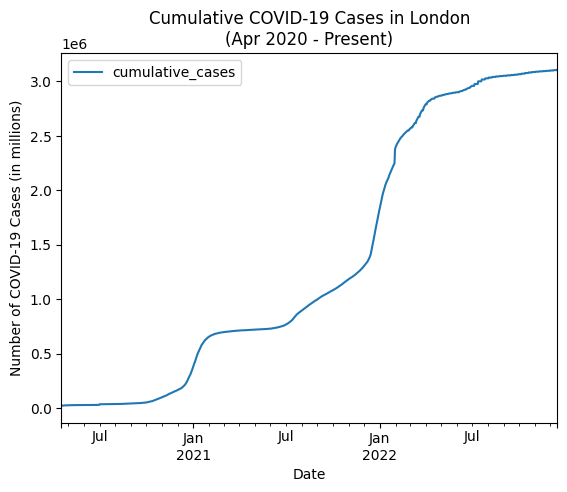

In [16]:
# Note: If a list of method is reused across multiple tasks, it has been
# copy pasted between tasks along with its relevant comments to help the marker.
# eg "column_sum_covid" method. This is done because each task is in its own
# cell. If this was one long python file I would not have done this.
#

# 1. Aggregate the data as an intermediate dataframe
# Creates a new DataFrame using "covid_data", dropping any rows where
# area != "London".
covid_data_london = covid_data.drop(
    covid_data[covid_data.area != "London"].index)

# 2. Plot to visualise the transformed data
# Plots this DataFrame as a line graph.
covid_data_london.plot(kind="line", x="date", y="cumulative_cases",
                       title="Cumulative COVID-19 Cases in London\n(Apr 2020 - Present)",
                       ylabel="Number of COVID-19 Cases (in millions)",
                       xlabel="Date")
show()

# 3. Answer the question posed
# There are multiple periods of time where the cases plateaued. For example,
# between Feburary 2021 - July 2021, there was little change in the number of
# cases. Additionally, another example of this is between
# August 2022 - December 2022.

## Task 16

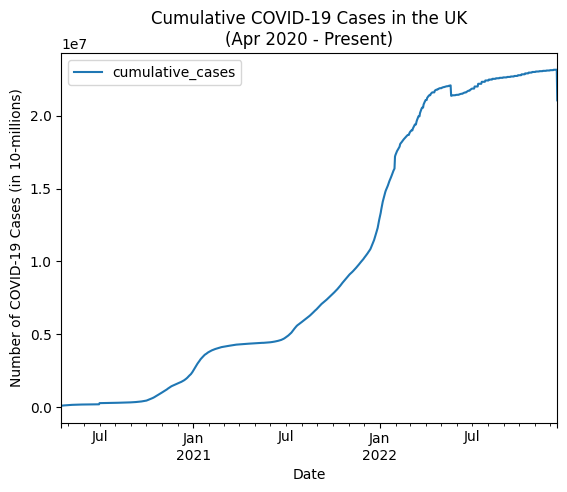

In [17]:
# 1. Aggregate the data as an intermediate dataframe
# Creates a Series with each row being a date in the "covid_data" DataFrame
# (with no duplicate dates; by only using the dates from a single area "London"). 
dates_df = covid_data.drop(
    covid_data[covid_data.area != "London"].index)["date"]

def column_sum_covid(date, column):
    """Calculates the sum of all numerical values in a given column of the
        "covid_data" DataFrame for all areas on a given date.

    Args:
        date (pandas Timestamp): Single date.
        column (string): Name of column for which to sum.

    Returns:
        (numpy.int64): Sum of all numerical values in a given "column".
    """
    # Drops all rows that do not contain the "date".
    current_data = covid_data.drop(
        covid_data[covid_data.date != date].index)
    return current_data[column].sum()

# Generates a DataFrame with each row holding one date and that dates cumulative
# cases across all areas.
all_areas_cum_cases = DataFrame({"date": dates_df})
all_areas_cum_cases["cumulative_cases"] = dates_df.apply(
    column_sum_covid, column="cumulative_cases")

# 2. Plot to visualise the transformed data
# Plots this DataFrame as a line graph.
all_areas_cum_cases.plot(kind="line", x="date", y="cumulative_cases",
                         title="Cumulative COVID-19 Cases in the UK\n(Apr 2020 - Present)",
                         ylabel="Number of COVID-19 Cases (in 10-millions)",
                         xlabel="Date")
show()

# 3. Answer the question posed
# The pattern seen in London greatly resembles the pattern seen country-wide.
# The shape of each regression line is quite similar.

## Task 17

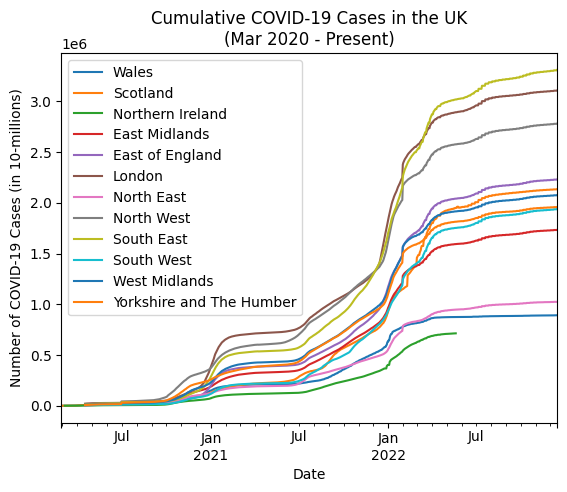

In [18]:
# 1. Aggregate the data as an intermediate dataframe
# List of all the nations and regions.
locations = ["Wales", "Scotland", "Northern Ireland",
             "East Midlands", "East of England", "London", "North East",
             "North West", "South East", "South West", "West Midlands",
             "Yorkshire and The Humber"]

# Wales has the largest date range out of all the areas, so is used here.
# Drops rows from "covid_data" where area != "Wales". Saves the "date" column.
covid_data_wales = covid_data.drop(
    covid_data[covid_data.area != "Wales"].index)["date"]
# Produces a list of all dates for which there exists COVID data.
dates = date_range(start=covid_data_wales.iloc[-1],
                      end=covid_data_wales.iloc[0])

def area_by_date(column, dates):
    """Generates a DataFrame with the first column being dates, and the rest 
        being areas. A single row will hold the "column" value for each area 
        for a single date.

    Args:
        column (string): Name of column to produce data for.
        dates (pandas DatetimeIndex): List of dates for which to produce data.

    Returns:
        (pandas DataFrame): First column is dates, all other columns are areas.
            A single row will hold the "column" value for each area for a single
            date.
    """
    area_by_date = DataFrame()
    for date in dates:  # For each date where there exists COVID data.
        # New row to be added to the "area_by_date" DataFrame.
        new_row = {"date": date}
        for location in locations:  # For each location.
            # Filters the data for the specified "date" and "location".
            current_data = covid_data[covid_data["date"] == date]
            current_data = current_data[current_data["area"] == location]
            # If there exists data for the specified "date" and "location".
            if not current_data.empty: 
                # Adds the data to the new row.
                new_row.update({location: current_data[column].iloc[0]})
            else:  # Else, adds a "Nan" value to that row instead.
                new_row.update({location: float("Nan")})
        # Adds the new row to the DataFrame.
        area_by_date = concat([area_by_date, DataFrame(new_row, index=[0])],
                              verify_integrity=True, ignore_index=True)
    return area_by_date

cases_by_area = area_by_date("cumulative_cases", dates)

# 2. Plot to visualise the transformed data
# Plots this DataFrame as a line graph.
cases_by_area.plot(kind="line", x="date",
                   title="Cumulative COVID-19 Cases in the UK\n(Mar 2020 - Present)",
                   ylabel="Number of COVID-19 Cases (in 10-millions)",
                   xlabel="Date")
show()

# 3. Answer the question posed
# All of the nations and regions share similar patterns. For example, each area
# experiences a spike in cases around January 2021, as well as around 
# January - March 2022.

## Task 18

In [19]:
# 3. Answer the question posed
# Three June - July periods can be seen on the graph. As the question did not
# specify the year, I will describe all three.
#
# June - July 2020: In June 2020, some lockdown restrictions were lifted. For
# example, schools and non-essential shops were re-opened, and the relaxation
# of certain restrictions including the 2m social distancing rule was announced
# by the PM. Around 4 months after these events, cases started to rise. The 
# events described could explain this, although the 4 month gap suggests that
# other factors were also involved.
# 
# June - July 2021: In June, the government decided to delay step 4 of the 
# "Roadmap out of lockdown". This step involved removing all legal limits on
# social contact and removing restrictions on businesses that were still closed,
# such as nightclubs. This step was delayed by a month, and was carried out in
# July. Right after July, there is a sharp spike in cases, which can be 
# explained by step 4 of the roadmap, as described.
#
# June - July 2022: There were little to no restrictions put in place by the 
# government in this time range. There was another mild spike in cases after
# July 2022. This may be explained by a range of factors; for example, July and
# August are usually the hottest months of the year in the UK, and generally
# during hot weather more people go outside to enjoy it. This could lead to a
# spike in cases. This reasoning also works for the 2020 and 2021 spikes in
# cases.

# Sources:
# - https://www.instituteforgovernment.org.uk/charts/uk-government-coronavirus-lockdowns
# - https://www.gov.uk/government/publications/covid-19-response-spring-2021/covid-19-response-spring-2021-summary
# - https://www.statista.com/statistics/322658/monthly-average-daily-temperatures-in-the-united-kingdom-uk/


## Task 19

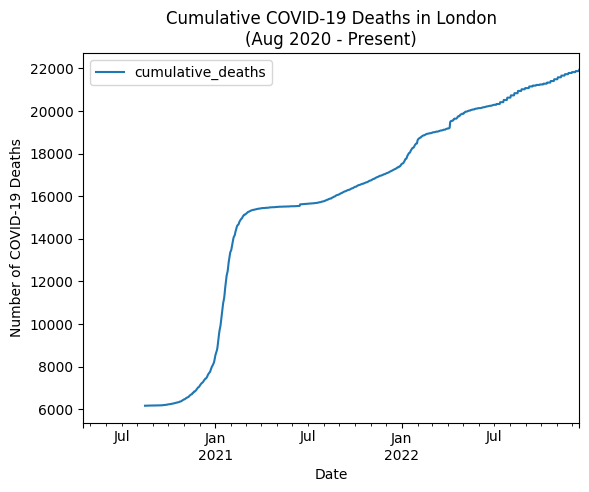

In [20]:
# 1. Aggregate the data as an intermediate dataframe
# Creates a Series with each row being a date in the "covid_data" DataFrame
# (with no duplicate dates; by only using the dates from a single area "London").
covid_data_london = covid_data.drop(
    covid_data[covid_data.area != "London"].index)

# 2. Plot to visualise the transformed data
# Plots this DataFrame as a line graph.
covid_data_london.plot(kind="line", x="date", y="cumulative_deaths",
                       title="Cumulative COVID-19 Deaths in London\n(Aug 2020 - Present)",
                       ylabel="Number of COVID-19 Deaths",
                       xlabel="Date")
show()

# 3. Answer the question posed
# Between around November 2020 - February 2021 there was a sharp spike in
# deaths. After this period, the trend is broken, wherein there are little new
# deaths recorded between around March - July 2021.

## Task 20

In [21]:
# 3. Answer the question posed
# There is some similarity between the trends in cumulative cases and cumulative
# deaths. This can be most clearly seen in the first large spike of cases, where
# around January 2021 a large spike in deaths accompanied this spike in cases.

## Task 21

<AxesSubplot:title={'center':'Cumulative COVID-19 Deaths per Cases in the UK\n(Apr 2020 - Present)'}, xlabel='Date', ylabel='Number of COVID-19 Deaths per 1000 cases'>

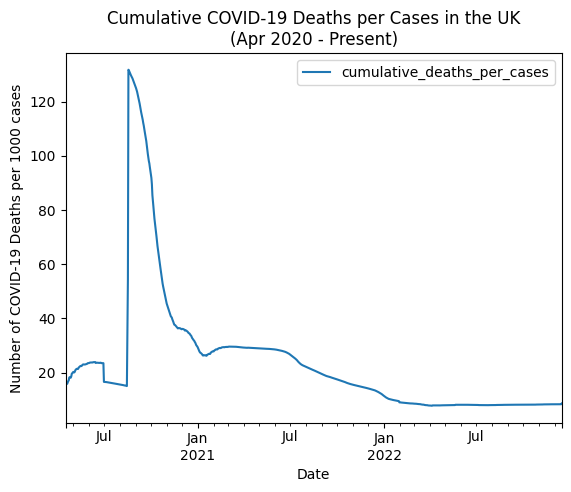

In [22]:
# 1. Aggregate the data as an intermediate dataframe
#
# Note: I have decided to calculate number of cumulative covid deaths per
# 1000 cases.
#

# Creates a Series with each row being a date in the "covid_data" DataFrame
# (with no duplicate dates; by only using the dates from a single area "London").
dates_df = covid_data.drop(
    covid_data[covid_data.area != "London"].index)["date"]

def generate_ratio(df):
    """Inserts a ratio column into the "df" of the ratio between
        "cumulative_deaths" and "cumulative_cases", per 1000 cases.

    Args:
        df (pandas DataFrame): DataFrame for which to produce a ratio column.
    """    
    ratio_list = []
    for _, row in df.iterrows():  # For each row in "df".
        try:  # Try and calculate and append the ratio for said row.
            ratio_list.append(
                (row["cumulative_deaths"] / row["cumulative_cases"]) * 1000)
        # If one of the values is Nan, append Nan instead.
        except: ratio_list.append(float("Nan"))
    df.insert(len(df.columns), "cumulative_deaths_per_cases", ratio_list)

generate_ratio(covid_data)

def column_sum_covid(date, column):
    """Calculates the sum of all numerical values in a given column of the
        "covid_data" DataFrame for all areas on a given date.

    Args:
        date (pandas Timestamp): Single date.
        column (string): Name of column for which to sum.

    Returns:
        (numpy.int64): Sum of all numerical values in a given "column" for a
            given "date".
    """
    # Drops all rows that do not contain the "date".
    current_data = covid_data.drop(
        covid_data[covid_data.date != date].index)
    return current_data[column].sum()

# Calculates cumulative cases and deaths for all areas as a single value for
# each date using the "column_sum_covid" method.
all_areas_cum_data = DataFrame({"date": dates_df})
all_areas_cum_data["cumulative_cases"] = dates_df.apply(
    column_sum_covid, column="cumulative_cases")
all_areas_cum_data["cumulative_deaths"] = dates_df.apply(
    column_sum_covid, column="cumulative_deaths")

generate_ratio(all_areas_cum_data)

# 2. Plot to visualise the transformed data
# Plots this DataFrame as a line graph.
all_areas_cum_data.plot(kind="line", x="date", y="cumulative_deaths_per_cases",
                        title="Cumulative COVID-19 Deaths per Cases in the UK\n(Apr 2020 - Present)",
                        ylabel="Number of COVID-19 Deaths per 1000 cases",
                        xlabel="Date")

# 3. Answer the question posed
# After the large spike in the deaths per 1000 cases ratio in August 2020, the 
# ratio generally trends negatively. This means that the number of deaths per 
# 1000 cases generally decreases after August 2020 over the next ~2.5 years.

## Task 22

In [23]:
# 3. Answer the question posed
# Three June - July periods can be seen on the graph. The question did not
# specify the year so I am assuming that the question refers to
# June - July 2021.
# 
# In June 2021, the government accelerated the vaccination programme, allowing
# more people to get vaccinated at a faster rate. Due to this, it is likely that
# the death rate fell, as the more vaccinated a population are from a certain
# disease, the less deaths happen in that population. If the death rate fell
# due to this decision by the government, the cumulative deaths per 1000 cases
# ratio is also going to decrease. This partially explains why the graph's 
# inclination gets steeper in this period of time.
#
# Sources: 
# - https://www.instituteforgovernment.org.uk/charts/uk-government-coronavirus-lockdowns
# - https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/999419/COVID-19_Response_Summer_2021.pdf

## Task 23

<AxesSubplot:title={'center':'Sum of cumulative vaccinations in the UK\n(Dec 2020 - Present)'}, xlabel='Date', ylabel='Number of COVID-19 vaccinations (in 10-millions)'>

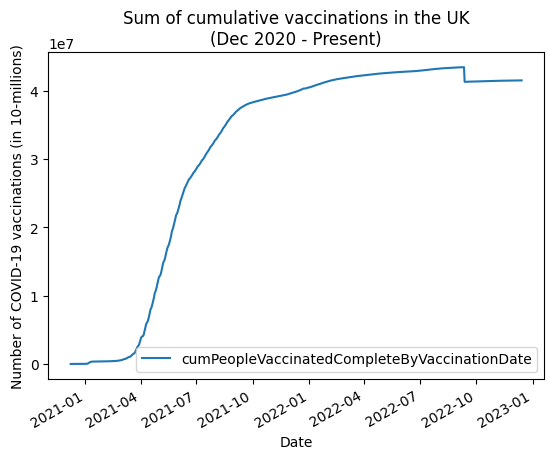

In [24]:
# This task takes ~20 mins to run on my machine. I could not find a way to make
# it more efficient. It does produce the desired output.
#

# 1. Aggregate the data as an intermediate dataframe
# Creates a Series with each row being a date in the "covid_data" DataFrame
# (with no duplicate dates; by only using the dates from a single area "London"). 
dates_df = covid_data_vaccinations_wide.drop(
    covid_data_vaccinations_wide[covid_data_vaccinations_wide.area != "London"].index)["date"]

def column_sum_vax(date, column):
    """Calculates the sum of all numerical values in a given column of the
        "covid_data_vaccinations_wide" DataFrame for all areas on a given date.

    Args:
        date (pandas Timestamp): Single date.
        column (string): Name of column for which to sum.

    Returns:
        (numpy.int64): Sum of all numerical values in a given "column".
    """
    # List of age intervals so that the non-intervals (eg "70+") are not used
    # so as to avoid duplicate data.
    ages = ["05_11", "12_15", "16_17", "18_24", "25_29", "30_34", "35_39",
            "40_44", "45_49", "50_54", "55_59", "60_64", "65_69", "70_74", 
            "75_79", "80_84", "85_89"]
    # Drops all rows that do not contain the "date".
    current_data = covid_data_vaccinations_wide.drop(
        covid_data_vaccinations_wide[covid_data_vaccinations_wide.date != date].index)
    # Drops all rows that do not contain the appropriate age intervals.
    current_data = current_data[current_data.age.isin(ages)]
    return current_data[column].sum()

# Generates a DataFrame with each row holding one date and that dates cumulative
# cases across all areas.
all_areas_cum_vax = DataFrame({"date": dates_df})
all_areas_cum_vax["cumPeopleVaccinatedCompleteByVaccinationDate"] = dates_df.apply(
    column_sum_vax, column="cumPeopleVaccinatedCompleteByVaccinationDate")

# 2. Plot to visualise the transformed data
# Plots this DataFrame as a line graph.
all_areas_cum_vax.plot(kind="line", x="date",
                       y="cumPeopleVaccinatedCompleteByVaccinationDate",
                       title="Sum of cumulative vaccinations in the UK\n(Dec 2020 - Present)",
                       ylabel="Number of COVID-19 vaccinations (in 10-millions)",
                       xlabel="Date")

# 3. Answer the question posed
# As the cumulative number of people with completed vaccines rises, the ratio of
# deaths per cases falls drastically. The largest spike in the deaths per cases
# ratio happened in August - September 2021, where there were around ~3 million
# completed vaccinations at the time; in comparison with ~4 million completed
# vaccinations at present.

## Task 24

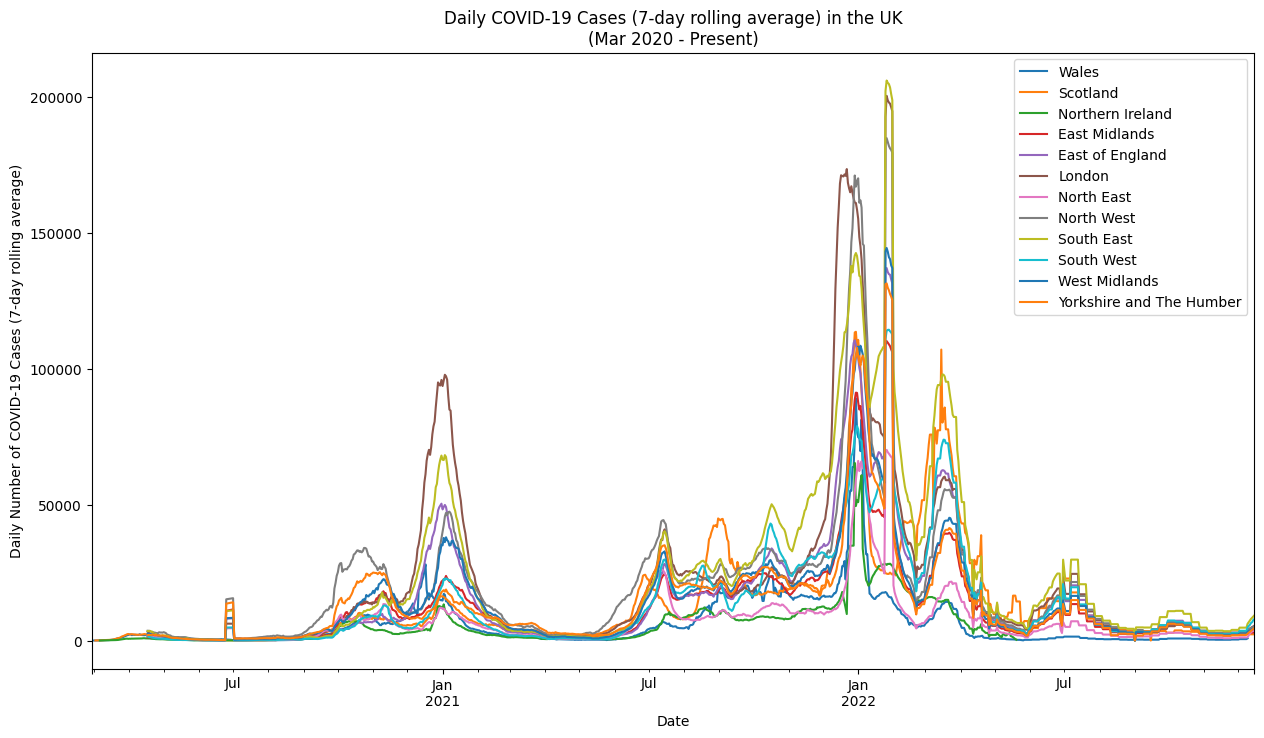

In [25]:
# 1. Aggregate the data as an intermediate dataframe
# List of all the nations and regions.
locations = ["Wales", "Scotland", "Northern Ireland",
             "East Midlands", "East of England", "London", "North East",
             "North West", "South East", "South West", "West Midlands",
             "Yorkshire and The Humber"]

# Wales has the largest date range out of all the areas, so is used here.
# Drops rows from "covid_data" where area != "Wales".
covid_data_wales = covid_data.drop(
    covid_data[covid_data.area != "Wales"].index)

# Produces a list of all dates for which there exists COVID data.
dates = date_range(start=covid_data_wales["date"].iloc[-1],
                   end=covid_data_wales["date"].iloc[0])

def area_by_date(column, dates):
    """Generates a DataFrame with the first column being dates, and the rest 
        being areas. A single row will hold the "column" value for each area 
        for a single date.

    Args:
        column (string): Name of column to produce data for.
        dates (pandas DatetimeIndex): List of dates for which to produce data.

    Returns:
        (pandas DataFrame): First column is dates, all other columns are areas.
            A single row will hold the "column" value for each area for a single
            date.
    """
    area_by_date = DataFrame()
    for date in dates:  # For each date where there exists COVID data.
        # New row to be added to the "area_by_date" DataFrame.
        new_row = {"date": date}
        for location in locations:  # For each location.
            # Filters the data for the specified "date" and "location".
            current_data = covid_data[covid_data["date"] == date]
            current_data = current_data[current_data["area"] == location]
            # If there exists data for the specified "date" and "location".
            if not current_data.empty: 
                # Adds the data to the new row.
                new_row.update({location: current_data[column].iloc[0]})
            else:  # Else, adds a "Nan" value to that row instead.
                new_row.update({location: float("Nan")})
        # Adds the new row to the DataFrame.
        area_by_date = concat([area_by_date, DataFrame(new_row, index=[0])],
                              verify_integrity=True, ignore_index=True)
    return area_by_date

rolling_cases_by_area = area_by_date("daily_cases_roll_avg", dates)

# 2. Plot to visualise the transformed data
# Plots this DataFrame as a line graph.
rolling_cases_by_area.plot(kind="line", x="date", figsize=(15, 8),
                           title="Daily COVID-19 Cases (7-day rolling average) in the UK\n(Mar 2020 - Present)",
                           ylabel="Daily Number of COVID-19 Cases (7-day rolling average)",
                           xlabel="Date")
show()

# 3. Answer the question posed
# The Wales area seems to escape some of the general trends for some dates. For
# example, a lot of the areas seem to have another spike in cases around
# June - August 2022. However the Wales daily number of cases stayed relatively
# similar between June - August 2022.

## Task 25

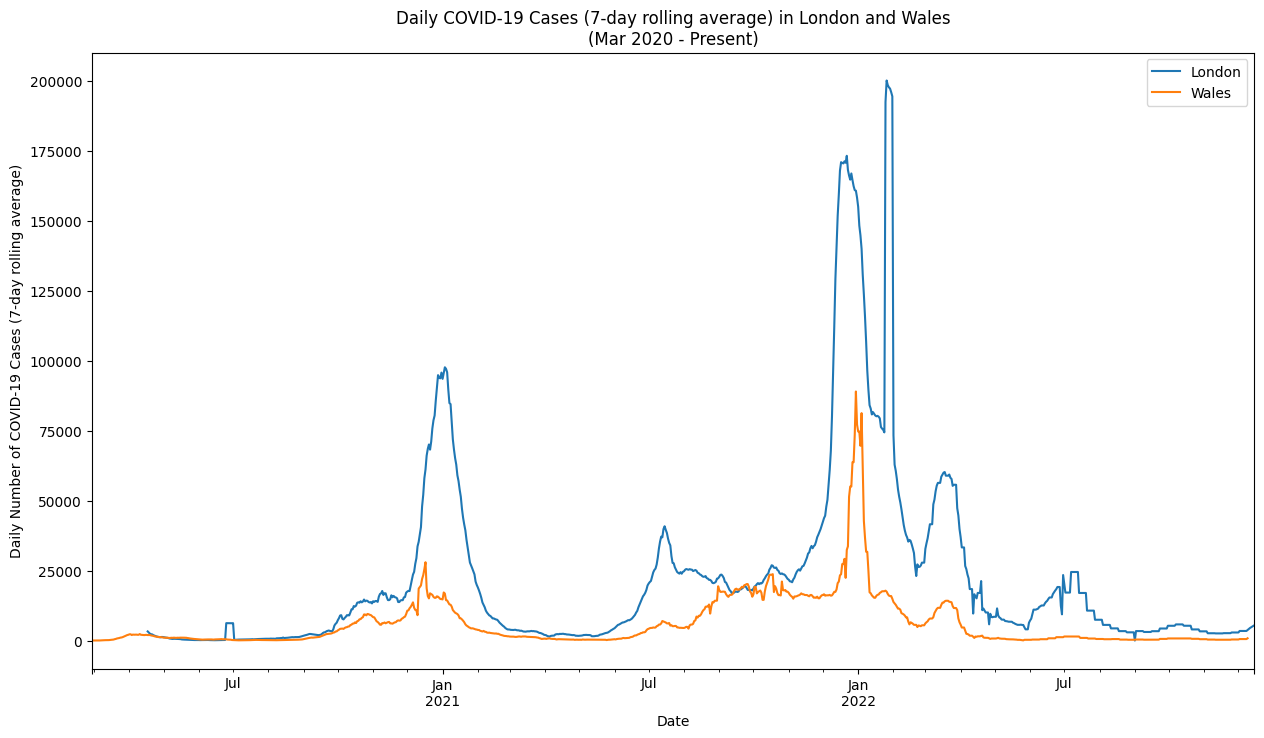

In [26]:
# 1. Aggregate the data as an intermediate dataframe
# List of all the nations and regions.
locations = ["London", "Wales"]

# Creates a Series with each row being a date in the "covid_data" DataFrame
# (with no duplicate dates; by only using the dates from a single area "Wales").
covid_data_wales = covid_data.drop(
    covid_data[covid_data.area != "Wales"].index)

def area_by_date(column, dates):
    """Generates a DataFrame with the first column being dates, and the rest 
        being areas. A single row will hold the "column" value for each area 
        for a single date.

    Args:
        column (string): Name of column to produce data for.
        dates (pandas DatetimeIndex): List of dates for which to produce data.

    Returns:
        (pandas DataFrame): First column is dates, all other columns are areas.
            A single row will hold the "column" value for each area for a single
            date.
    """
    area_by_date = DataFrame()
    for date in dates:  # For each date where there exists COVID data.
        # New row to be added to the "area_by_date" DataFrame.
        new_row = {"date": date}
        for location in locations:  # For each location.
            # Filters the data for the specified "date" and "location".
            current_data = covid_data[covid_data["date"] == date]
            current_data = current_data[current_data["area"] == location]
            # If there exists data for the specified "date" and "location".
            if not current_data.empty: 
                # Adds the data to the new row.
                new_row.update({location: current_data[column].iloc[0]})
            else:  # Else, adds a "Nan" value to that row instead.
                new_row.update({location: float("Nan")})
        # Adds the new row to the DataFrame.
        area_by_date = concat([area_by_date, DataFrame(new_row, index=[0])],
                              verify_integrity=True, ignore_index=True)
    return area_by_date

rolling_cases_lon_wal = area_by_date("daily_cases_roll_avg", dates)

# 2. Plot to visualise the transformed data
# Plots this DataFrame as a line graph.
rolling_cases_lon_wal.plot(kind="line", x="date", figsize=(15, 8),
                           title="Daily COVID-19 Cases (7-day rolling average) in London and Wales\n(Mar 2020 - Present)",
                           ylabel="Daily Number of COVID-19 Cases (7-day rolling average)",
                           xlabel="Date")
show()

# 3. Answer the question posed
# As these results display the raw number of cases rather than the per capita
# values, some of the differences seen here may be explained by the populations
# of each of these areas. Wales has a population of ~3.2 million, while London
# has a population of ~9 million, nearly 3 times as large. Another reason for 
# these differences might be the differences in population density. London has a 
# population density of ~5200 population per square KM, while Wales in
# comparison has a population density of 150 per square KM. A larger population
# is likely to lead to a higher number of daily cases. The higher the 
# population density of an area, the higher the number daily cases in that area.
# This is because the more people that live in an area, the higher the 
# likelihood that the virus spreads within the population, leading to a rise in
# cases.
#
# Sources:
# - https://www.statista.com/statistics/294729/uk-population-by-region/
# - https://www.trustforlondon.org.uk/data/geography-population/
# - https://www.gov.wales/population-and-household-estimates-wales-census-2021-html

## Task 26

<AxesSubplot:title={'center':'Normalized Daily COVID-19 Cases & deaths(7-day rolling average) in the UK\n(Apr 2020 - Present)'}, xlabel='Date', ylabel='Normalized Daily Number of COVID-19 Cases\n& Deaths(7-day rolling average)'>

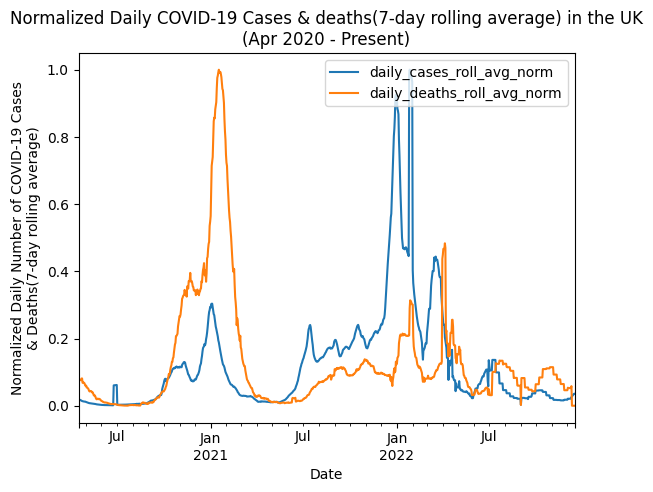

In [27]:
# 1. Aggregate the data as an intermediate dataframe
# Creates a Series with each row being a date in the "covid_data" DataFrame
# (with no duplicate dates; by only using the dates from a single area "London").
dates_df = covid_data.drop(
    covid_data[covid_data.area != "London"].index)["date"]

def column_sum_covid(date, column):
    """Calculates the sum of all numerical values in a given column of the
        "covid_data" DataFrame for all areas on a given date.

    Args:
        date (pandas Timestamp): Single date.
        column (string): Name of column for which to sum.

    Returns:
        (numpy.int64): Sum of all numerical values in a given "column".
    """
    # Drops all rows that do not contain the "date".
    current_data = covid_data.drop(
        covid_data[covid_data.date != date].index)
    return current_data[column].sum()

# Sums the rolling daily cases and deaths for all areas for each date using the
# "column_sum_covid" method.
roll_avg_norm = DataFrame()
roll_avg_norm["date"] = dates_df
roll_avg_norm["daily_cases_roll_avg"] = dates_df.apply(
    column_sum_covid, column="daily_cases_roll_avg")
roll_avg_norm["daily_deaths_roll_avg"] = dates_df.apply(
    column_sum_covid, column="daily_deaths_roll_avg")

# Takes the maximum value in each column used for normalization.
max_cases = roll_avg_norm["daily_cases_roll_avg"].max()
max_deaths = roll_avg_norm["daily_deaths_roll_avg"].max()

# Normalizes each value in the daily rolling cases and deaths columns.
roll_avg_norm["daily_cases_roll_avg_norm"] = roll_avg_norm[
    "daily_cases_roll_avg"].apply(lambda cases: cases / max_cases)
roll_avg_norm["daily_deaths_roll_avg_norm"] = roll_avg_norm[
    "daily_deaths_roll_avg"].apply(lambda deaths: deaths / max_deaths)

# Drops the appropriate columns.
roll_avg_norm = roll_avg_norm.drop(
    ["daily_cases_roll_avg", "daily_deaths_roll_avg"], axis = 1)

# 2. Plot to visualise the transformed data
# Plots this DataFrame as a line graph.
roll_avg_norm.plot(kind="line", x="date",
                   title="Normalized Daily COVID-19 Cases & deaths(7-day rolling average) in the UK\n(Apr 2020 - Present)",
                   ylabel="Normalized Daily Number of COVID-19 Cases\n& Deaths(7-day rolling average)",
                   xlabel="Date")

# 3. Answer the question posed
# In around the January 2021 spike in cases and deaths, the daily rolling deaths
# both increased and then subsequently decreased at a much higher rate compared
# to the daily rolling cases. On the other hand, between around
# December 2021 - June 2022, The daily rolling cases increased and then 
# decreased at much larger rates compared to the daily rolling deaths.
# This information has been gathered by looking at the peaks of the regression
# lines, and comparing the peaks of each line at the same time periods. If there
# is a great difference between the peaks, this suggests that there is a large
# difference between the rates of change between cases and deaths.

## Task 27

<AxesSubplot:title={'center':'Vaccination Rate in London by Age\n(Dec 2020 - Present)'}, xlabel='Date', ylabel='Vaccination Rate (percentage of population vaccinated)'>

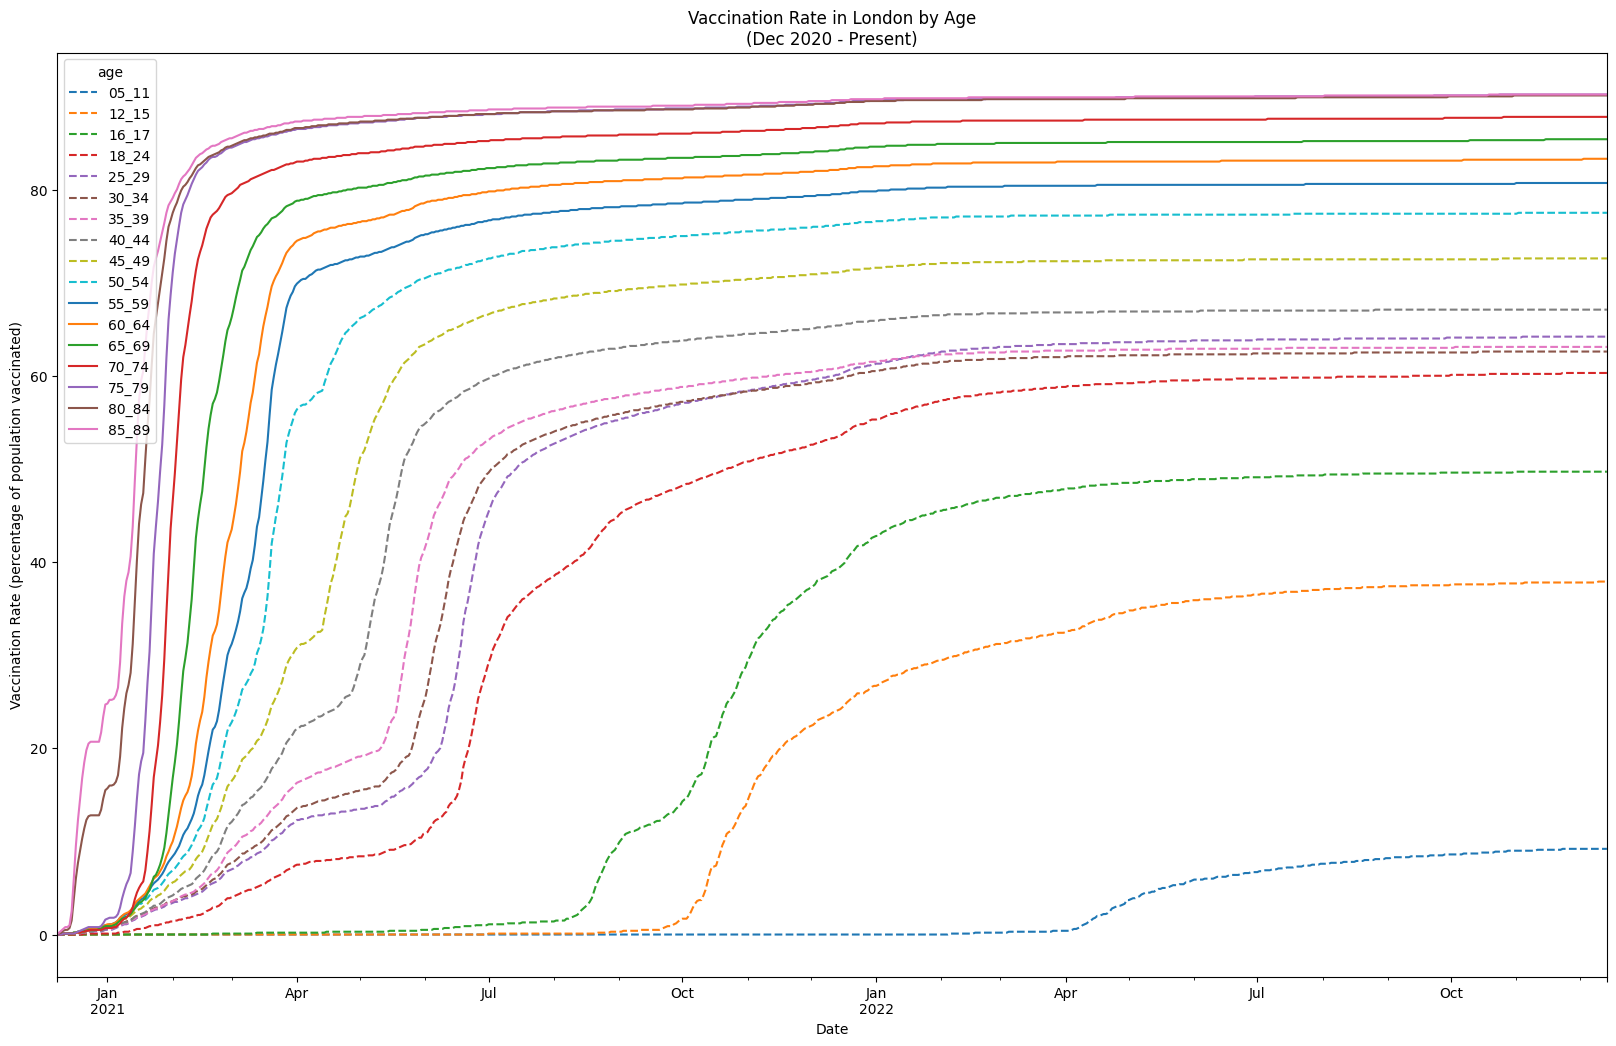

In [28]:
# 1. Aggregate the data as an intermediate dataframe
vaccine_london = covid_data_vaccinations_wide.drop(
    covid_data_vaccinations_wide[
        covid_data_vaccinations_wide.area != "London"].index)

# As the question askes specifically for intervals, all of the non-intervals
# (eg "70+") are removed.
ages = ["05_11", "12_15", "16_17", "18_24", "25_29", "30_34", "35_39", "40_44",
        "45_49", "50_54", "55_59", "60_64", "65_69", "70_74", "75_79", "80_84",
        "85_89"]
# Drops all rows that do not contain the appropriate age intervals.
vaccine_london = vaccine_london[vaccine_london.age.isin(ages)]

# Groups the data by the columns "date" and "age". Selects only the
# "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage" column.
vaccine_london = vaccine_london.groupby(["date", "age"])[
    "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]

# For any values where the date and age intervals are the same, combines these
# into a single row with the relevant
# "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage" values stored.
# Then, runs "unstack()", using the dates as indexes and age intervals as
# column names, creating a DataFrame.
first_dose_london = vaccine_london.aggregate("first").unstack()
# Turns the "date" index column into an actual column to plot the graph.
first_dose_london.reset_index(inplace=True)

# 2. Plot to visualise the transformed data
# Plots this DataFrame as a line graph.
first_dose_london.plot(kind="line", x="date", figsize=(20, 12),
                       style=["--" for _ in range(10)],
                       title="Vaccination Rate in London by Age\n(Dec 2020 - Present)",
                       ylabel="Vaccination Rate (percentage of population vaccinated)",
                       xlabel="Date")

# 3. Answer the question posed
# All age groups were not equally vaccinated at the same time. The strategy
# employed seems to be to vaccinate the older age groups first before moving
# to the younger ones. This is because we can see from the graph that the older 
# the age group, the more likely they were to get the vaccine earlier than the 
# other younger age groups. Additionally, the younger the age group, the lower
# the total vaccination rate for that age group.

## Task 28

<AxesSubplot:title={'center':'Vaccination Rate in Scotland by Age\n(Dec 2020 - Present)'}, xlabel='Date', ylabel='Vaccination Rate (percentage of population vaccinated)'>

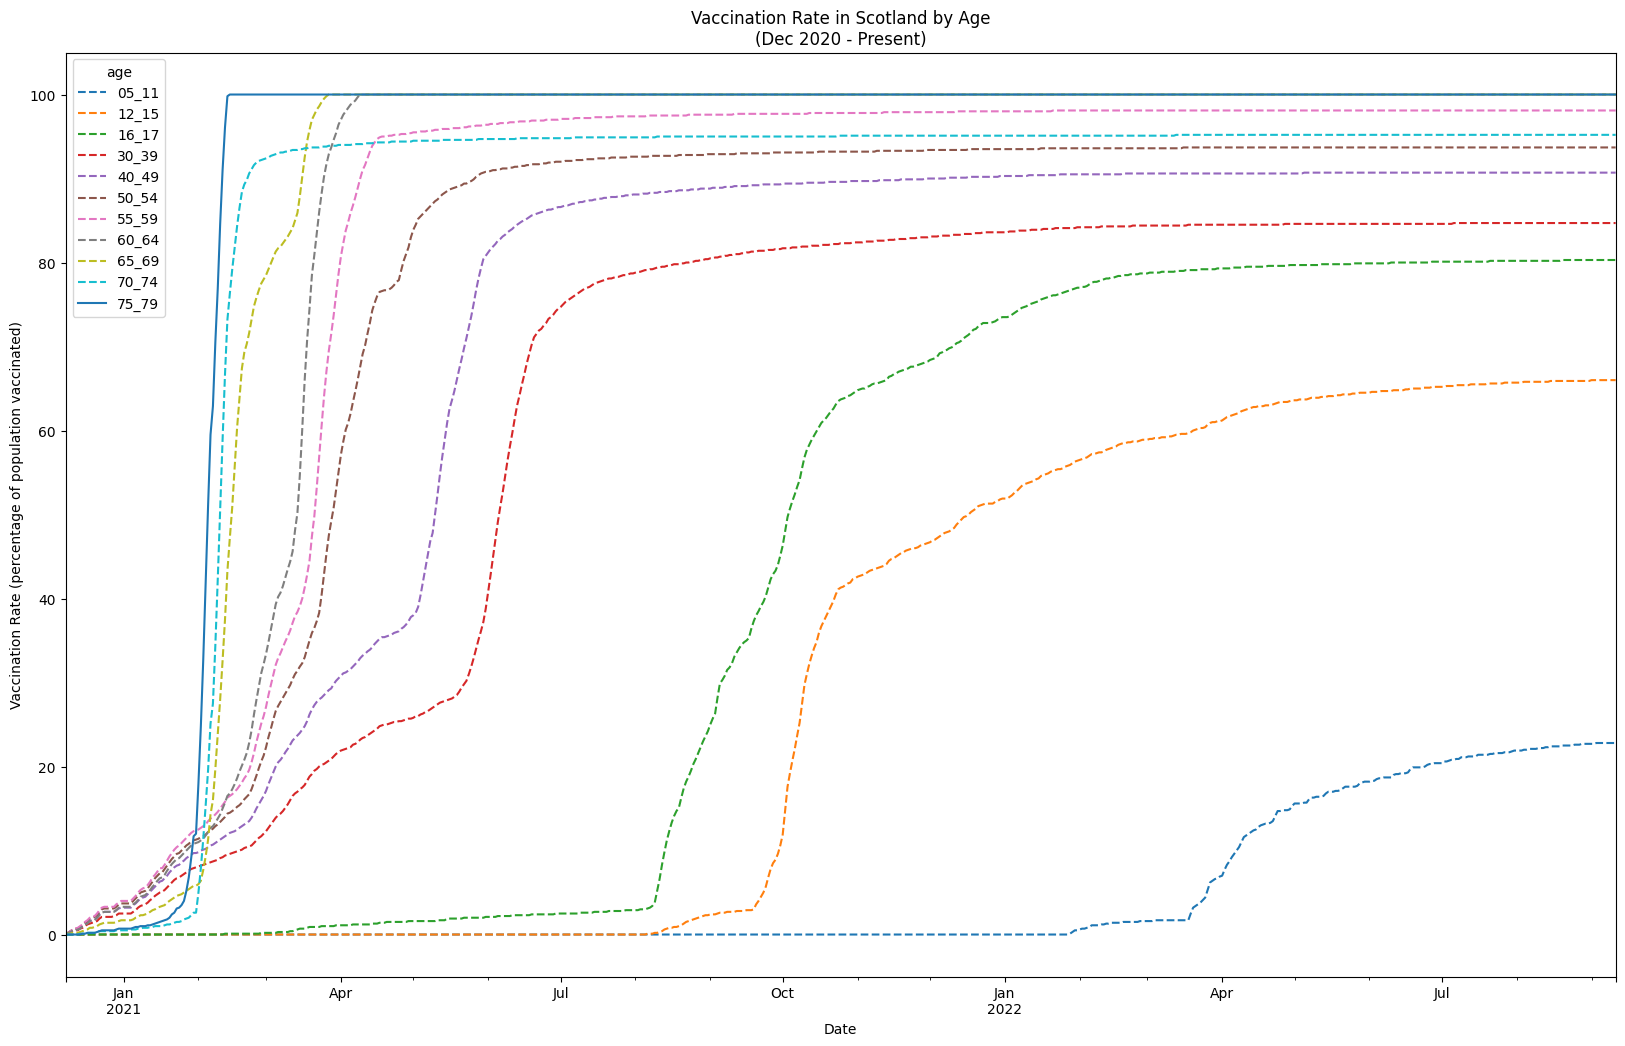

In [29]:
# 1. Aggregate the data as an intermediate dataframe
vaccine_scotland = covid_data_vaccinations_wide.drop(
    covid_data_vaccinations_wide[covid_data_vaccinations_wide.area != "Scotland"].index)

# The age intervals for Scotland are different from the ones for London, so a
# new list is declared with the correct intervals. Once again the question asked
# for intervals, so all of the non intervals (eg "80+") are removed.
ages_scotland = ["05_11", "12_15", "16_17", "30_39", "40_49", "50_54", "55_59",
                 "60_64", "65_69", "70_74", "75_79"]
vaccine_scotland = vaccine_scotland[vaccine_scotland.age.isin(ages_scotland)]

# Groups the data by the columns "date" and "age". Selects only the
# "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage" column.
vaccine_scotland = vaccine_scotland.groupby(["date", "age"])[
    "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]

# For any values where the date and age intervals are the same, combines these
# into a single row with the relevant
# "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage" values stored.
# Then, runs "unstack()", using the dates as indexes and age intervals as
# column names, creating a DataFrame.
first_dose_scotland = vaccine_scotland.aggregate("first").unstack()
# Turns the "date" index column into an actual column to plot the graph.
first_dose_scotland.reset_index(inplace=True)

# 2. Plot to visualise the transformed data
# Plots this DataFrame as a line graph.
first_dose_scotland.plot(kind="line", x="date", figsize=(20, 12),
                         style=["--" for _ in range(10)],
                         title="Vaccination Rate in Scotland by Age\n(Dec 2020 - Present)",
                         ylabel="Vaccination Rate (percentage of population vaccinated)",
                         xlabel="Date")

# 3. Answer the question posed
# Based on the graphs, vaccines were made available to the 50-64 and 65-79 age
# groups between December - January 2021 in both London and Scotland.
#
# In London, people aged 50-64 were then vaccinated heavily until around
# April 2021, where the rate of vaccination started to slow down at stabilized
# at ~70%. In comparison, people aged 65-79 in London were vaccinated heavily
# until between February - March 2021, where the vaccination rate hit ~80% and
# started to slow down, meaning that the majority of this age group was
# vaccinated around a month before the 50-64 age group. There was little change
# in vaccination rates for both age groups past January 2022, where the 50-64
# age group stabilized at ~80%, and the 65-79 age group stabilized at ~87%.
#
# In Scotland, a lot of vaccines were given to people aged 50-64 until around
# April 2021, where the vaccination rate hit ~93%, which is substantially better
# than the same age group in London by this time period. The number of new
# people getting the vaccine greatly decreased after April 2021 for this age
# group. As for the 65-79 age group, the majority of this population was
# vaccinated in a month long period between half way through January and half
# way through February 2021, whereby the vaccination rate saw little change
# after February 2021.
# 
# For both age groups, Scotland, in comparison with London, managed to
# distribute their vaccines at a faster rate than London once the vaccines had
# begun being distributed. However, London managed to distribute the vaccine
# earlier in general. Additionally, Scotland managed to vaccinate a larger total
# percentage of their populations than London. Once the majority of the
# population in each area was vaccinated and the rate of vaccination slowed
# down, Scotland's rates seemed to stabilize faster, meaning they saw much
# smaller changes in vaccination rates than in London past May 2021 for the
# specified age groups.